## Health Care Cost Prediction with Frequentist/Bayesian Linear Regression Models

- description : 

Original dataset/Frequentist model : https://www.kaggle.com/code/ruslankl/health-care-cost-prediction-w-linear-regression/input 

Bayesian model : implemented by me (reference : statistical rethinking book 2nd edition )

In [1]:
## Setting up the environment and df import

library(ggplot2)
library(dplyr)
library(Hmisc)
library(cowplot)
library(WVPlots)
set.seed(123)

df <- read.csv("insurance.csv")
sample_n(df, 5)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'Hmisc'


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:base':

    format.pval, units


Loading required package: wrapr


Attaching package: 'wrapr'


The following object is masked from 'package:dplyr':

    coalesce




age,sex,bmi,children,smoker,region,charges
<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
19,female,35.150,0,no,northwest,2134.901
62,female,38.095,2,no,northeast,15230.324
46,female,28.900,2,no,southwest,8823.279
18,female,33.880,0,no,southeast,11482.635
18,male,34.430,0,no,southeast,1137.470



## Understanding the data

* **Age**: insurance contractor age, years

* **Sex**: insurance contractor gender, [female, male]

* **BMI**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
<center>![](https://2o42f91vxth73xagf92zhot2-wpengine.netdna-ssl.com/blog/wp-content/uploads/sites/4/2017/07/Chart.jpg)</center>

* **Children**: number of children covered by health insurance / Number of dependents

* **Smoker**: smoking, [yes, no]

* **Region**: the beneficiary's residential area in the US, [northeast, southeast, southwest, northwest]

* **Charges**: Individual medical costs billed by health insurance, $ *#predicted value*

<!-- ```{r describe, message=FALSE, warning=FALSE, paged.print=TRUE} -->

In [2]:
describe(df)

df 

 7  Variables      1338  Observations
--------------------------------------------------------------------------------
age 
       n  missing distinct     Info     Mean  pMedian      Gmd      .05 
    1338        0       47    0.999    39.21       39    16.21       18 
     .10      .25      .50      .75      .90      .95 
      19       27       39       51       59       62 

lowest : 18 19 20 21 22, highest: 60 61 62 63 64
--------------------------------------------------------------------------------
sex 
       n  missing distinct 
    1338        0        2 
                        
Value      female   male
Frequency     662    676
Proportion  0.495  0.505
--------------------------------------------------------------------------------
bmi 
       n  missing distinct     Info     Mean  pMedian      Gmd      .05 
    1338        0      548        1    30.66    30.52    6.893    21.26 
     .10      .25      .50      .75      .90      .95 
   22.99    26.30    30.40    34.69 

No missing values at this point in the dfset. 

## Exploratory Data Analysis
```{r EDA, message=FALSE, warning=FALSE, paged.print=TRUE}
```

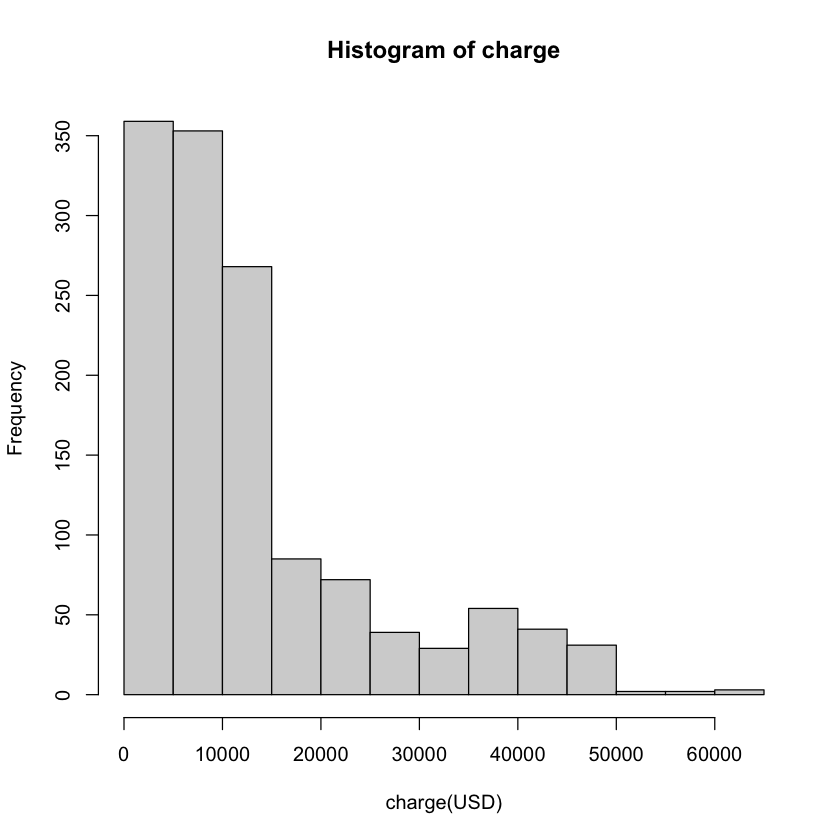

In [3]:
hist(df$charge, main = "Histogram of charge", xlab = "charge(USD)")

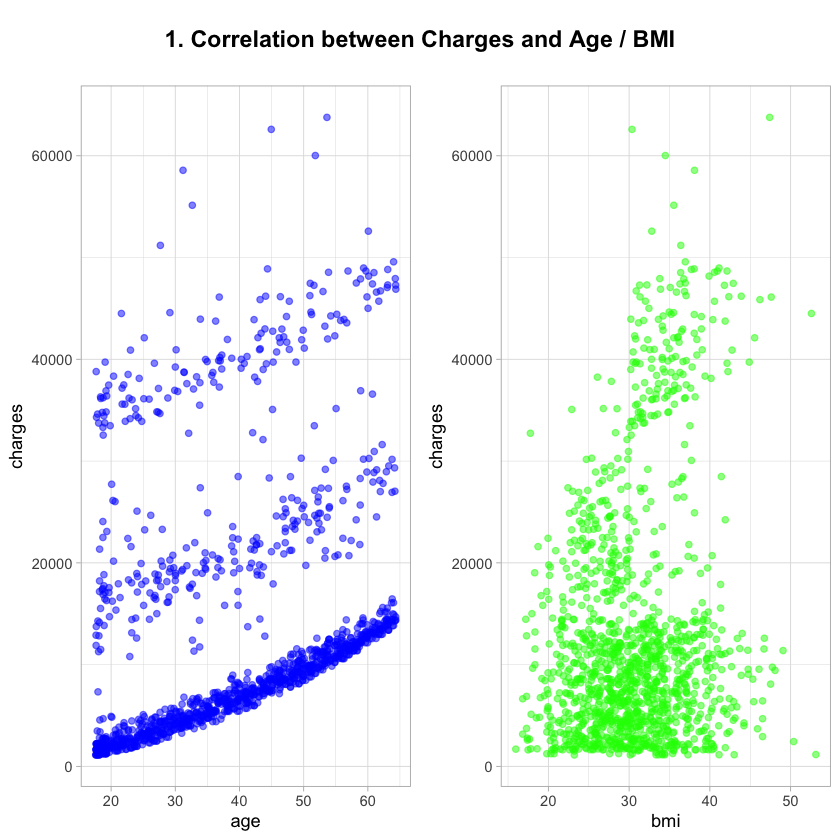

In [4]:
x <- ggplot(df, aes(age, charges)) +
  geom_jitter(color = "blue", alpha = 0.5) +
  theme_light()

y <- ggplot(df, aes(bmi, charges)) +
  geom_jitter(color = "green", alpha = 0.5) + 
  theme_light()

p <- plot_grid(x, y) 
title <- ggdraw() + draw_label("1. Correlation between Charges and Age / BMI", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1))

* **Plot 1**: As Age and BMI go up Charges for health insurance also trends up.


**left plot (Age vs charges)**

The left plot shows a clear positive correlation between age and medical charges. As people get older, their medical expenses tend to increase. 

Furthermore, the layered appearance of data points suggests that age may interact with other variables, such as smoking status or BMI, influencing medical charges in a more complex way.


**Right plot (BMI vs charges)** 

 Unlike age, the correlation here is weaker and more scattered. While there is a slight upward trend, particularly among individuals with higher BMI (above 35), the association is not consistent. This suggests that BMI alone is not a strong predictor of medical charges, and its effect may depend on interactions with other variables such as age or smoking status.

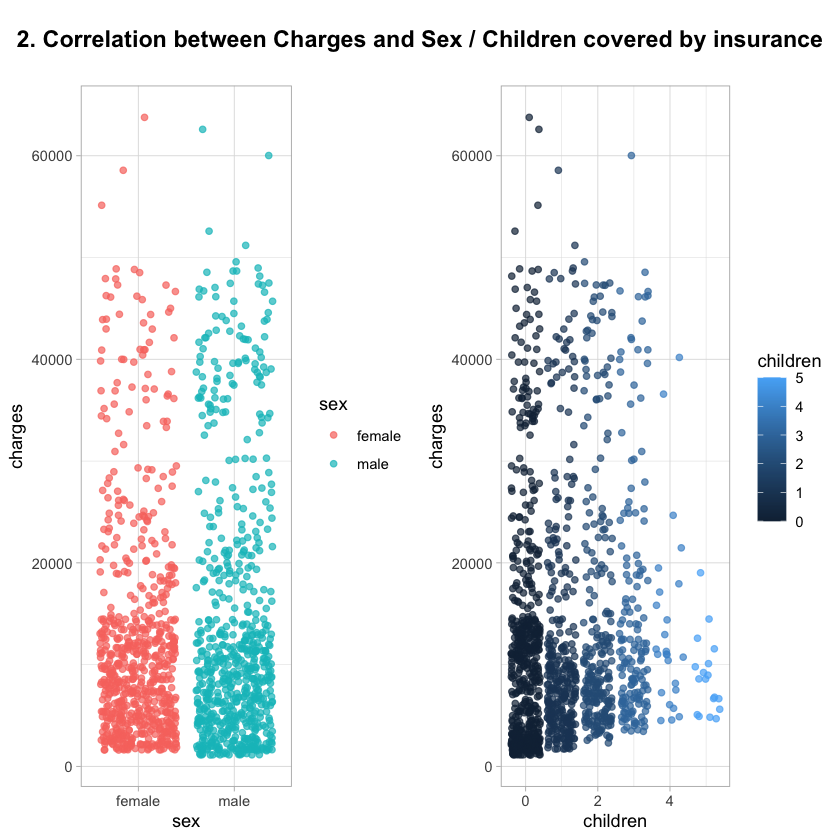

In [5]:
x <- ggplot(df, aes(sex, charges)) +
  geom_jitter(aes(color = sex), alpha = 0.7) +
  theme_light()

y <- ggplot(df, aes(children, charges)) +
  geom_jitter(aes(color = children), alpha = 0.7) +
  theme_light()

p <- plot_grid(x, y) 
title <- ggdraw() + draw_label("2. Correlation between Charges and Sex / Children covered by insurance", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1))


* **Plot 2**: Overall, there is no significant difference in the distribution of charges between males and females. Both groups exhibit similar spread and variation. This suggests that sex may not be a strong standalone predictor of healthcare costs in this dataset.


Charges for insurance with 4-5 chilren covered seems to go down (doesn't make sense, does it?)

 Most charges in this group are below $20,000, and high-cost outliers are rare. This suggests that having 4 children may correlate with a specific socioeconomic or insurance coverage profile that reduces costs—though further analysis is needed to confirm this. In general, the number of children alone still shows limited predictive power.

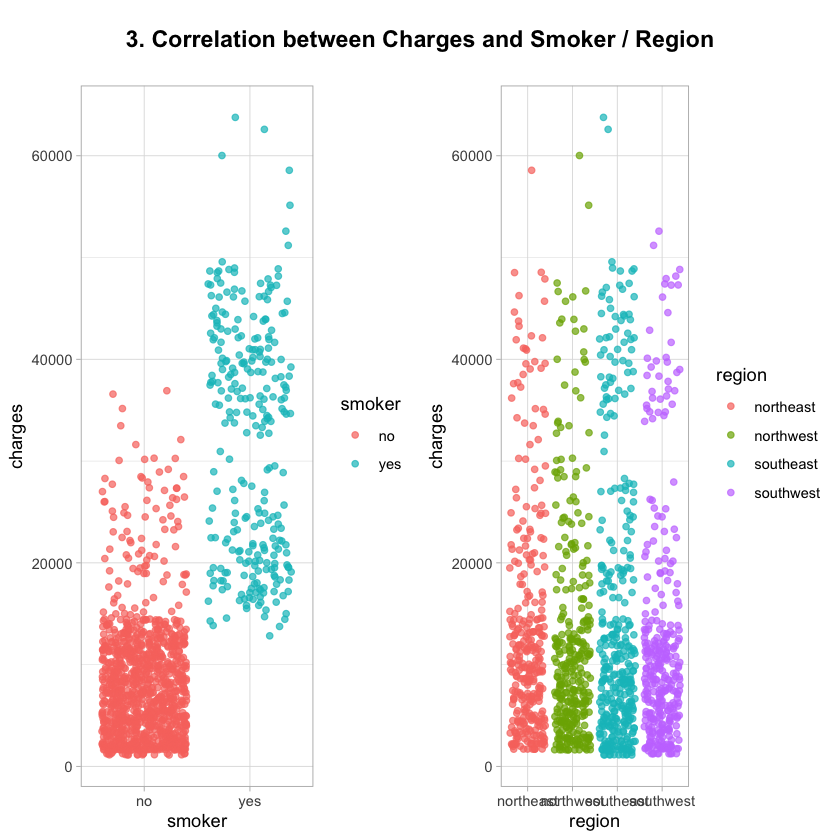

In [6]:
x <- ggplot(df, aes(smoker, charges)) +
  geom_jitter(aes(color = smoker), alpha = 0.7) +
  theme_light()

y <- ggplot(df, aes(region, charges)) +
  geom_jitter(aes(color = region), alpha = 0.7) +
  theme_light()

p <- plot_grid(x, y) 
title <- ggdraw() + draw_label("3. Correlation between Charges and Smoker / Region", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1))


* **Plot 3**: Charges for Smokers are higher for non-smokers (no surprise here). No obvious connection between Charges and Region.

## Linear Regression Model
### Preparation and splitting the data

Train-80%, Test-20%

In [7]:
n_train <- round(0.8 * nrow(df))
train_indices <- sample(1:nrow(df), n_train)
df_train <- df[train_indices, ]
df_test <- df[-train_indices, ]

formula_0 <- as.formula("charges ~ age + sex + bmi + children + smoker + region")

### Train and Test the Model

In [8]:
model_0 <- lm(formula_0, data = df_train)
summary(model_0)


Call:
lm(formula = formula_0, data = df_train)

Residuals:
   Min     1Q Median     3Q    Max 
-11641  -2730  -1007   1246  29856 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -10797.10    1091.13  -9.895  < 2e-16 ***
age                246.01      13.26  18.547  < 2e-16 ***
sexmale           -145.62     370.71  -0.393  0.69453    
bmi                316.82      31.74   9.981  < 2e-16 ***
children           482.75     153.77   3.140  0.00174 ** 
smokeryes        24025.29     459.93  52.237  < 2e-16 ***
regionnorthwest   -518.66     526.15  -0.986  0.32447    
regionsoutheast  -1035.07     532.03  -1.946  0.05198 .  
regionsouthwest  -1083.97     531.67  -2.039  0.04172 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6029 on 1061 degrees of freedom
Multiple R-squared:  0.7525,	Adjusted R-squared:  0.7506 
F-statistic: 403.3 on 8 and 1061 DF,  p-value: < 2.2e-16


In [9]:
#Saving R-squared
r_sq_0 <- summary(model_0)$r.squared

#predict data on test set
prediction_0 <- predict(model_0, newdata = df_test)

#calculating the residuals
residuals_0 <- df_test$charges - prediction_0

#calculating Root Mean Squared Error
rmse_0 <- sqrt(mean(residuals_0^2))


As we can see, summary of a model showed us that some of the variable are not significant (*sex*), while *smoking* seems to have a huge influence on *charges*. Training a model without non-significant variables and check if performance can be improved.

### Train and Test New Model

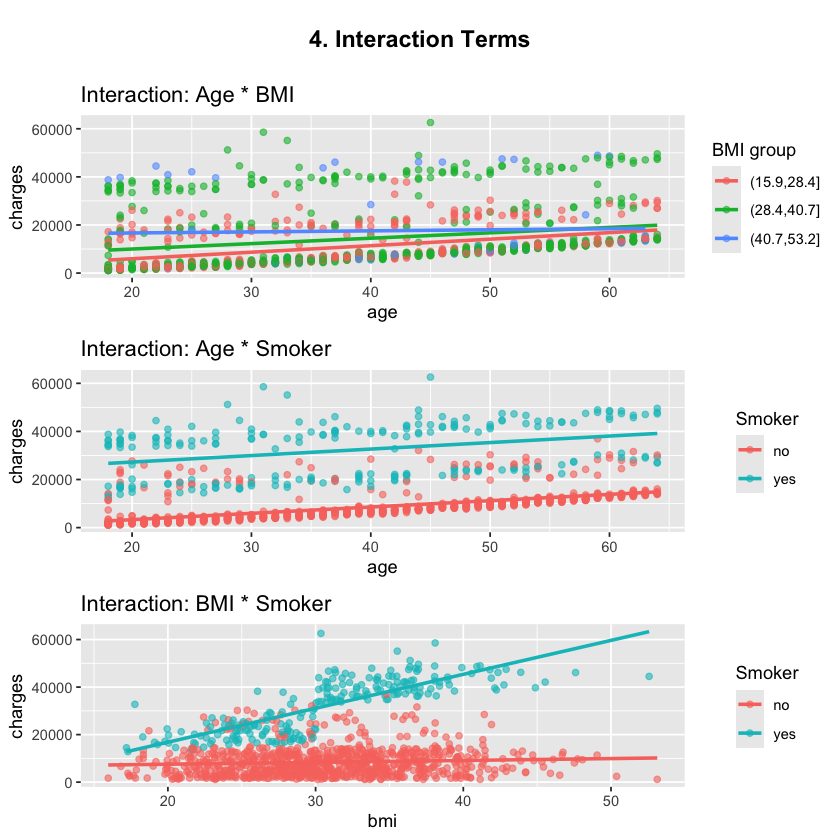

In [10]:
library(ggplot2)
library(cowplot)  # 꼭 필요함

# 1. age * BMI
x <- ggplot(df_train, aes(x = age, y = charges, color = cut(bmi, breaks=3))) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", formula = y ~ x, se = FALSE) +
  labs(title = "Interaction: Age * BMI", color = "BMI group")

# 2. BMI * smoker
y <- ggplot(df_train, aes(x = bmi, y = charges, color = smoker)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", formula = y ~ x, se = FALSE) +
  labs(title = "Interaction: BMI * Smoker", color = "Smoker")

# 3. age * smoker (오타 수정: charge → charges)
z <- ggplot(df_train, aes(x = age, y = charges, color = smoker)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", formula = y ~ x, se = FALSE) +
  labs(title = "Interaction: Age * Smoker", color = "Smoker")

# Combine plots
p <- plot_grid(x, z, y, ncol = 1, align = "v")
title <- ggdraw() + draw_label("4. Interaction Terms", fontface = 'bold')

# Final layout
plot_grid(title, p, ncol = 1, rel_heights = c(0.1, 1))


In [11]:
# formula_1 <- as.formula("charges ~ age*bmi + bmi*smoker + age*smoker + bmi + children  +region ") # except sex

# model_1 <- lm(formula_1, data = df_train)
# summary(model_1)
# r_sq_1 <- summary(model_1)$r.squared

# pred_1 <- predict(model_1, newdata = df_test)

# residuals_1 <- df_test$charges - pred_1
# rmse_1 <- sqrt(mean(residuals_1^2))

In [12]:
df_train$age2 <- df_train$age^2
df_test$age2 <- df_test$age^2


formula_1 <- as.formula("charges ~ age + age2 + bmi*smoker + children  +region ") # except sex

model_1 <- lm(formula_1, data = df_train)
summary(model_1)
r_sq_1 <- summary(model_1)$r.squared

pred_1 <- predict(model_1, newdata = df_test)

residuals_1 <- df_test$charges - pred_1
rmse_1 <- sqrt(mean(residuals_1^2))


Call:
lm(formula = formula_1, data = df_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-14600.5  -1598.2  -1282.4   -837.2  31050.6 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.423e+03  1.532e+03   2.234  0.02570 *  
age             -4.837e+01  7.252e+01  -0.667  0.50490    
age2             3.882e+00  9.038e-01   4.295 1.91e-05 ***
bmi              4.506e+00  2.823e+01   0.160  0.87320    
smokeryes       -1.978e+04  1.833e+03 -10.796  < 2e-16 ***
children         6.674e+02  1.280e+02   5.214 2.22e-07 ***
regionnorthwest -7.088e+02  4.183e+02  -1.694  0.09050 .  
regionsoutheast -1.176e+03  4.230e+02  -2.779  0.00554 ** 
regionsouthwest -1.197e+03  4.227e+02  -2.831  0.00473 ** 
bmi:smokeryes    1.425e+03  5.841e+01  24.396  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4794 on 1060 degrees of freedom
Multiple R-squared:  0.8436,	Adjusted R-squared:  0.8423 
F

### Compare the models

In [13]:
coefs <- summary(model_1)$coefficients
round(coefs, 2)  

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),3422.88,1532.30,2.23,0.03
age,-48.37,72.52,-0.67,0.50
age2,3.88,0.90,4.29,0.00
bmi,4.51,28.23,0.16,0.87
smokeryes,-19784.94,1832.63,-10.80,0.00
children,667.41,128.01,5.21,0.00
regionnorthwest,-708.75,418.31,-1.69,0.09
regionsoutheast,-1175.82,423.04,-2.78,0.01
regionsouthwest,-1196.65,422.69,-2.83,0.00
bmi:smokeryes,1424.89,58.41,24.40,0.00


In [14]:
print(paste0("R-squared for first model:", round(r_sq_0, 4)))
print(paste0("R-squared for new model: ", round(r_sq_1, 4)))
print(paste0("RMSE for first model: ", round(rmse_0, 2)))
print(paste0("RMSE for new model: ", round(rmse_1, 2)))

[1] "R-squared for first model:0.7525"
[1] "R-squared for new model: 0.8436"
[1] "RMSE for first model: 6213.11"
[1] "RMSE for new model: 4902.42"



As we can see, performance is quite similar between two models so I will keep the new model since it's a little bit simpler.

In [15]:
### Model Performance

# df_test$prediction <- predict(model_1, newdata = df_test)
# ggplot(df_test, aes(x = prediction, y = charges)) + 
#   geom_point(color = "blue", alpha = 0.7) + 
#   geom_abline(color = "red") +
#   ggtitle("Prediction vs. Real values")

# df_test$residuals <- df_test$charges - df_test$prediction

# ggplot(data = df_test, aes(x = prediction, y = residuals)) +
#   geom_pointrange(aes(ymin = 0, ymax = residuals), color = "blue", alpha = 0.7) +
#   geom_hline(yintercept = 0, linetype = 3, color = "red") +
#   ggtitle("Residuals vs. Linear model prediction")

# ggplot(df_test, aes(x = residuals)) + 
#   geom_histogram(bins = 15, fill = "blue") +
#   ggtitle("Histogram of residuals")

# GainCurvePlot(df_test, "prediction", "charges", "Model")

We can see the errors in the model are close to zero so model predicts quite well.

# Compare to Bayesian linear regression model 

In [16]:
# install package
# install.packages(c("devtools", "coda", "mvtnorm", "matrixStats"))
devtools::install_github("rmcelreath/rethinking")


library(rethinking)
library(tidyverse)

Skipping install of 'rethinking' from a github remote, the SHA1 (ac1b3b2c) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: cmdstanr

This is cmdstanr version 0.8.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /Users/hwang-yejin/.cmdstan/cmdstan-2.36.0

- CmdStan version: 2.36.0

Loading required package: posterior

This is posterior version 1.6.0


Attaching package: 'posterior'


The following objects are masked from 'package:stats':

    mad, sd, var


The following objects are masked from 'package:base':

    %in%, match


Loading required package: parallel

Warning message in (function (n) :
"strings not representable in native encoding will be translated to UTF-8"
Warning message in (function (n) :
"strings not representable in native encoding will be translated to UTF-8"
Warning message in (function (n) :
"strings not representable in native encoding will be translated to UTF-8"
rethinking

In [17]:
head(df)

,age,sex,bmi,children,smoker,region,charges
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,19,female,27.900,0,yes,southwest,16884.924
2,18,male,33.770,1,no,southeast,1725.552
3,28,male,33.000,3,no,southeast,4449.462
4,33,male,22.705,0,no,northwest,21984.471
5,32,male,28.880,0,no,northwest,3866.855
6,31,female,25.740,0,no,southeast,3756.622


In [18]:
df$sex <- as.factor(df$sex)
df$smoker <- as.factor(df$smoker)
df$region <- as.factor(df$region)

In [19]:
# install.packages(c("devtools", "tidyverse"))
# devtools::install_github("rmcelreath/rethinking")

# Variable Processing
df <- df %>%
  mutate(
    smoker = ifelse(smoker == "yes", 1, 0),
    sex = as.integer(factor(sex)) - 1,
    region = as.integer(factor(region)),  # 1~4
    charges = charges / 10000,            # scale down
    bmi = (bmi - mean(bmi)) / sd(bmi),
    age = (age - mean(age)) / sd(age)
  )

In [20]:
## without interaction term

# Data list to be used
# dat_list <- list(
#   charges = df$charges,
#   age = df$age,
#   age2 = df$age^2,
#   bmi = df$bmi,
#   smoker = df$smoker,
#   region = df$region
# )


# # Bayesian Hierarchical Linear Regression (rethinking + ulam)
# m_bayes <- ulam(
#   alist(
#     charges ~ dnorm(mu, sigma),
#     mu <- a[region] + bA*age + bA2*age2 + bB*bmi + bS*smoker + bI*bmi*smoker,
    
#     # Priors
#     a[region] ~ dnorm(a_bar, sigma_region),
#     a_bar ~ dnorm(0, 1),
#     bA ~ dnorm(0, 1),
#     bA2 ~ dnorm(0, 0.5),
#     bB ~ dnorm(0, 1),
#     bS ~ dnorm(0, 1),
#     bI ~ dnorm(0, 1), #interaction term(bmi*smoker)
#     sigma_region ~ dexp(1),
#     sigma ~ dexp(1)
#   ),
#   data = dat_list,
#   chains = 4,
#   cores = 4,
#   iter = 4000,
#   log_lik = TRUE
# )

In [21]:
dat_list <- list(
  charges = df$charges,
  age = df$age,
  age2 = df$age^2,
  bmi = df$bmi,
  smoker = df$smoker,
  region = df$region,
  children = df$children
)

m_bayes <- ulam(
  alist(
    charges ~ dnorm(mu, sigma),

    mu <- a[region] +
          bA * age +
          bA2 * age2 +        
          bB * bmi +
          bS * smoker +       
          bI * bmi * smoker + 
          bC * children,

    a[region] ~ dnorm(a_bar, sigma_region),
    a_bar ~ dnorm(0, 1),

    # Priors
    bA ~ dnorm(0, 1),
    bA2 ~ dnorm(0, 0.5),
    bB ~ dnorm(0, 1),
    bS ~ dnorm(0, 1),
    bI ~ dnorm(0, 2),       # interaction term → wider
    bC ~ dnorm(0, 1),
    sigma_region ~ dexp(1),
    sigma ~ student_t(3, 0, 2)  # 더 안정적인 분포
  ),
  data = dat_list,
  chains = 4, cores = 4,
  iter = 4000,
  log_lik = TRUE,
  control = list(adapt_delta = 0.99, max_treedepth = 15)
)


Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:    1 / 4000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is -3626.11, but must be positive! (in '/var/folders/pq/ywh3rrys6n9dnn8yfd90rznm0000gn/T/RtmpselLuA/model-37bb9c0bc7e.stan', line 37, column 4 to column 35)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is -33.0081, but must be positive! (in '/var/folders/pq/ywh3rrys6n9dnn8yfd90rznm0000gn/T/RtmpselLuA/model-37bb9c0bc7e.stan', line 37, column 4 to column 35)

Chain 1 If this warning occurs sporadically, such as for highly constrained vari

Chain 2 Iteration:    1 / 4000 [  0%]  (Warmup) 


Chain 3 Rejecting initial value:

Chain 3   Error evaluating the log probability at the initial value.

Chain 3 Exception: normal_lpdf: Scale parameter is -0.579841, but must be positive! (in '/var/folders/pq/ywh3rrys6n9dnn8yfd90rznm0000gn/T/RtmpselLuA/model-37bb9c0bc7e.stan', line 37, column 4 to column 35)

Chain 3 Exception: normal_lpdf: Scale parameter is -0.579841, but must be positive! (in '/var/folders/pq/ywh3rrys6n9dnn8yfd90rznm0000gn/T/RtmpselLuA/model-37bb9c0bc7e.stan', line 37, column 4 to column 35)

Chain 3 Rejecting initial value:

Chain 3   Error evaluating the log probability at the initial value.

Chain 3 Exception: normal_lpdf: Scale parameter is -0.814426, but must be positive! (in '/var/folders/pq/ywh3rrys6n9dnn8yfd90rznm0000gn/T/RtmpselLuA/model-37bb9c0bc7e.stan', line 37, column 4 to column 35)

Chain 3 Exception: normal_lpdf: Scale parameter is -0.814426, but must be positive! (in '/var/folders/pq/ywh3rrys6n9dnn8yfd90rznm0000gn/T/RtmpselLuA/model-37bb9c0bc7e.stan

Chain 3 Iteration:    1 / 4000 [  0%]  (Warmup) 
Chain 4 Iteration:    1 / 4000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 4000 [  2%]  (Warmup) 
Chain 1 Iteration:  100 / 4000 [  2%]  (Warmup) 
Chain 3 Iteration:  100 / 4000 [  2%]  (Warmup) 
Chain 4 Iteration:  100 / 4000 [  2%]  (Warmup) 
Chain 3 Iteration:  200 / 4000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 4000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 4000 [  5%]  (Warmup) 
Chain 4 Iteration:  200 / 4000 [  5%]  (Warmup) 
Chain 1 Iteration:  300 / 4000 [  7%]  (Warmup) 
Chain 2 Iteration:  300 / 4000 [  7%]  (Warmup) 
Chain 3 Iteration:  300 / 4000 [  7%]  (Warmup) 
Chain 2 Iteration:  400 / 4000 [ 10%]  (Warmup) 
Chain 3 Iteration:  400 / 4000 [ 10%]  (Warmup) 
Chain 4 Iteration:  300 / 4000 [  7%]  (Warmup) 
Chain 1 Iteration:  400 / 4000 [ 10%]  (Warmup) 
Chain 2 Iteration:  500 / 4000 [ 12%]  (Warmup) 
Chain 4 Iteration:  400 / 4000 [ 10%]  (Warmup) 
Chain 1 Iteration:  500 / 4000 [ 12%]  (Warmup) 
Chain 3 Iteration:  

See https://mc-stan.org/misc/warnings for details.




In [22]:
precis(m_bayes, depth = 2)

,mean,sd,5.5%,94.5%,rhat,ess_bulk
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],0.75647597,0.037017649,0.69737312,0.81534236,1.000594,3179.635
a[2],0.70632372,0.035192934,0.65071844,0.76272944,1.000708,3277.199
a[3],0.65588925,0.034848647,0.60097880,0.71189982,1.000401,3117.549
a[4],0.65382788,0.035675805,0.59686141,0.71071261,1.000061,3449.681
a_bar,0.68656155,0.086205270,0.59139100,0.78273907,1.002358,1799.225
bA,0.36646392,0.013438788,0.34521645,0.38798128,1.000753,7265.132
bA2,0.07366381,0.015966326,0.04860666,0.09909054,1.000337,3353.504
bB,0.01035157,0.015337207,-0.01408597,0.03488432,1.000410,5432.374
bS,2.37726936,0.032430441,2.32550615,2.42898165,1.000930,6261.116


All Rhat values are ~1.00, indicating excellent convergence. 

The effective sample sizes (ess_bulk) for all parameters are above 2000, with several exceeding 7000, indicating that the posterior estimates are based on a large number of effectively independent samples.

Parameters such as bS (smoker effect) show strong influence with low uncertainty, while region-level variance (sigma_region) exhibits relatively higher uncertainty.

In [23]:
show(m_bayes) # model formula , how long each chain took to run 

Hamiltonian Monte Carlo approximation
8000 samples from 4 chains

Sampling durations (seconds):
  chain_id warmup sampling total
1        1   7.10    11.69 18.79
2        2   6.86     7.36 14.22
3        3   6.65    16.75 23.40
4        4   7.22     7.46 14.68

Formula:
charges ~ dnorm(mu, sigma)
mu <- a[region] + bA * age + bA2 * age2 + bB * bmi + bS * smoker + 
    bI * bmi * smoker + bC * children
a[region] ~ dnorm(a_bar, sigma_region)
a_bar ~ dnorm(0, 1)
bA ~ dnorm(0, 1)
bA2 ~ dnorm(0, 0.5)
bB ~ dnorm(0, 1)
bS ~ dnorm(0, 1)
bI ~ dnorm(0, 2)
bC ~ dnorm(0, 1)
sigma_region ~ dexp(1)
sigma ~ student_t(3, 0, 2)


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



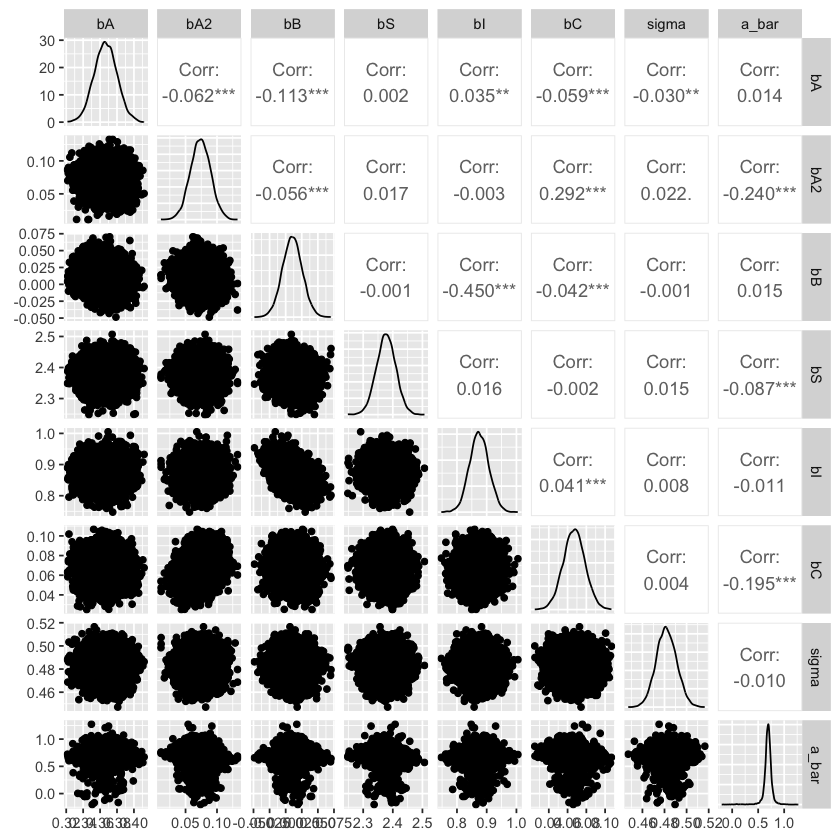

In [24]:
library(GGally)

post_full <- extract.samples(m_bayes)

post <- data.frame(
  bA = post_full$bA,
  bA2 = post_full$bA2,
  bB = post_full$bB,
  bS = post_full$bS,
  bI = post_full$bI,
  bC = post_full$bC,
  sigma = post_full$sigma,
  a_bar = post_full$a_bar
)

ggpairs(post)

The ggpairs plot indicates that all four parameters (bS, bA, sigma, a_bar) exhibit approximately normal posterior distributions. The pairwise correlations are very low (all |r| < 0.10), suggesting no significant collinearity among predictors. The scatterplots further confirm that the posterior samples are well-behaved and decorrelated.



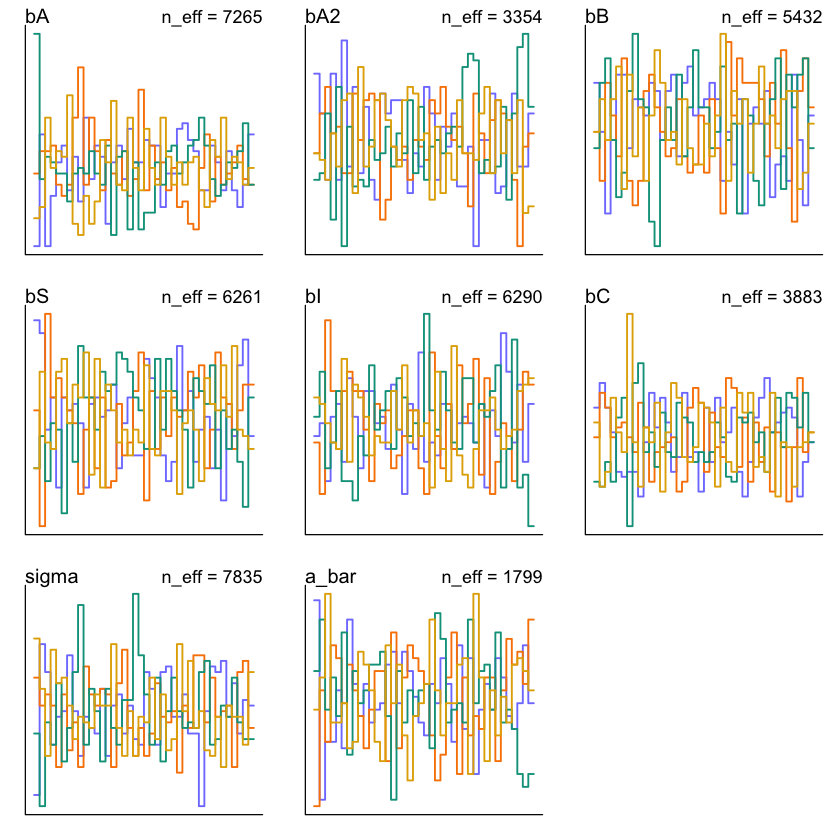

In [25]:
trankplot(m_bayes, pars = c("bA", "bA2", "bB", "bS", "bI", "bC","sigma", "a_bar"))

In [26]:
# trankplot(m_bayes, pars = c("bS", "bA", "sigma", "a_bar"))

The rank-normalized trace plots for the key parameters (bS, bA, sigma, and a_bar) indicate good convergence across all four MCMC chains. All chains show stable mixing behavior with no evident drifts or divergences.

The effective sample sizes (n_eff) are consistently high, with bA, bS, and sigma each exceeding 7000, suggesting high-quality and reliable posterior estimates. The parameter a_bar has a slightly lower n_eff of 2464 but still reflects adequate convergence.

Overall, the trace plots confirm that the chains have converged well, and the posterior inference is based on a sufficiently large number of independent samples

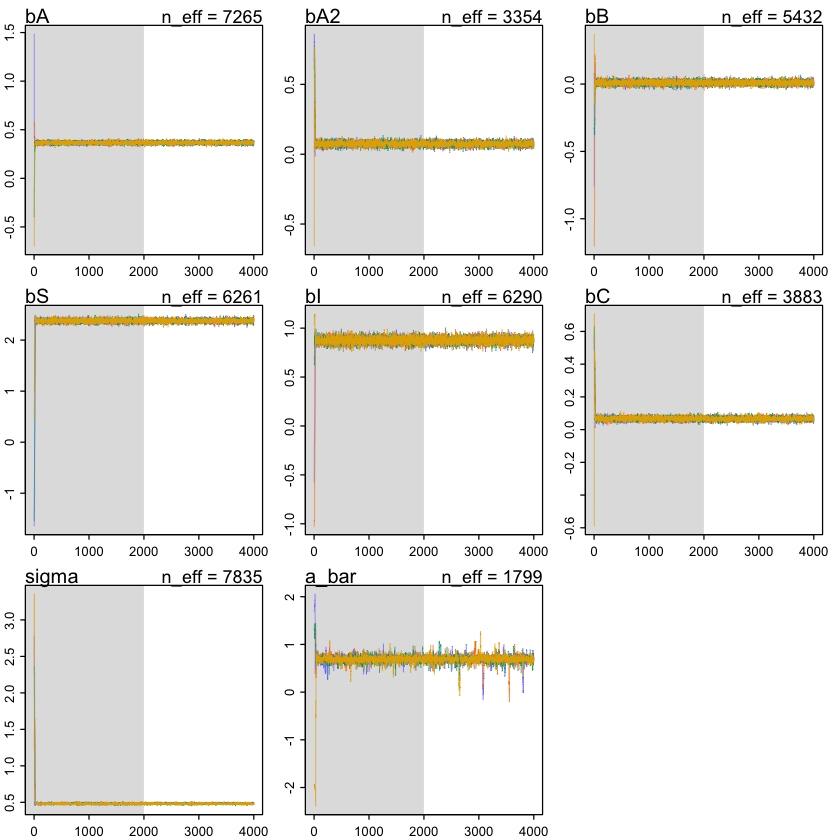

In [27]:
traceplot(m_bayes, pars = c("bA", "bA2", "bB", "bS", "bI", "bC","sigma", "a_bar"))


The traceplots show that all chains have converged well, with good mixing and no evidence of divergence.
All chains for bS, bA, and sigma are tightly clustered and show consistent behavior after the warm-up period.
Although a_bar exhibits some early variability, it quickly stabilizes, supporting the reliability of posterior inference.

In [28]:
# Posterior prediction 
post <- extract.samples(m_bayes)

df$age2 <- df$age^2


mu_link <- link(m_bayes, data=df)  # posterior predictive distribution
mu_pred <- apply(mu_link, 2, mean)  # 각 관측치에 대한 평균 예측


# Calculation of Prediction Performance Metrics
true <- df$charges
pred <- mu_pred


# RMSE
rmse_bayes <- sqrt(mean((true - pred)^2))

# MAE
mae_bayes <- mean(abs(true - pred))


# R² 
TSS <- sum((true - mean(true))^2)
RSS <- sum((true - pred)^2)
r2_bayes <- 1 - RSS / TSS

# WAIC
waic_bayes <- WAIC(m_bayes)

In [29]:
# Summary of performance


performance_bayes <- data.frame(
  Model = "Bayesian Linear Regression (full)",
  RMSE = rmse_bayes*10000,
  MAE = mae_bayes*10000,
  R2 = r2_bayes,
  WAIC = waic_bayes$WAIC
)

performance_freq <- data.frame(
  Model = "Frequentist Linear Regression",
  RMSE = rmse_1,
  MAE = mean(abs(df_test$charges - pred_1)),
  R2 = r_sq_1,
  WAIC = NA  # frequentist에선 NA로 표시
)


performance_all <- rbind(performance_freq, performance_bayes)
print(performance_all)



                              Model     RMSE      MAE        R2     WAIC
1     Frequentist Linear Regression 4902.423 2956.411 0.8436493       NA
2 Bayesian Linear Regression (full) 4796.795 2888.051 0.8429861 1857.318


### Applying on new data

Let's imagine 3 different people and see what charges on health care will be for them.

1. **Bob**: 19 years old, BMI 27.9, has no children, smokes, from northwest region.

2. **Lisa**: 40 years old, BMI 50, 2 children, doesn't smoke, from southeast region.

3. **John**: 30 years old. BMI 31.2, no children, doesn't smoke, from northeast region.


In [30]:
# Bob <- data.frame(age = 19,
#                   bmi = 27.9,
#                   children = 0,
#                   smoker = "yes",
#                   region = "northwest")
# print(paste0("Health care charges for Bob: ", round(predict(model_1, Bob), 2)))

# Lisa <- data.frame(age = 40,
#                    bmi = 50,
#                    children = 2,
#                    smoker = "no",
#                    region = "southeast")
# print(paste0("Health care charges for Lisa: ", round(predict(model_1, Lisa), 2)))

# John <- data.frame(age = 30,
#                    bmi = 31.2,
#                    children = 0,
#                    smoker = "no",
#                    region = "northeast")
# print(paste0("Health care charges for John: ", round(predict(model_1, John), 2)))
